# ============================================================================
# Micro Gas Turbine Electrical Energy Prediction: A Numerical Modeling Approach
# ============================================================================

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmcrameri import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as XGBRegressor
import lightgbm as LGBMRegressor
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
sns.set_palette("inferno")

# 1. Data Loading and Initial Inspection

Loading training data...
Loaded 6 training experiments

Loading test data...
Loaded 2 test experiments

Processing training data with feature engineering...
Processing test data with feature engineering...

Training data shape: (52880, 13)
Test data shape: (18265, 13)

Training data information:
<class 'pandas.core.frame.DataFrame'>
Index: 52880 entries, 10 to 52939
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 52880 non-null  float64
 1   input_voltage        52880 non-null  float64
 2   el_power             52880 non-null  float64
 3   experiment           52880 non-null  int64  
 4   input_voltage_lag1   52880 non-null  float64
 5   input_voltage_lag5   52880 non-null  float64
 6   input_voltage_lag10  52880 non-null  float64
 7   input_voltage_diff   52880 non-null  float64
 8   input_voltage_diff5  52880 non-null  float64
 9   input_voltage_ma5    52880 non-null  float6

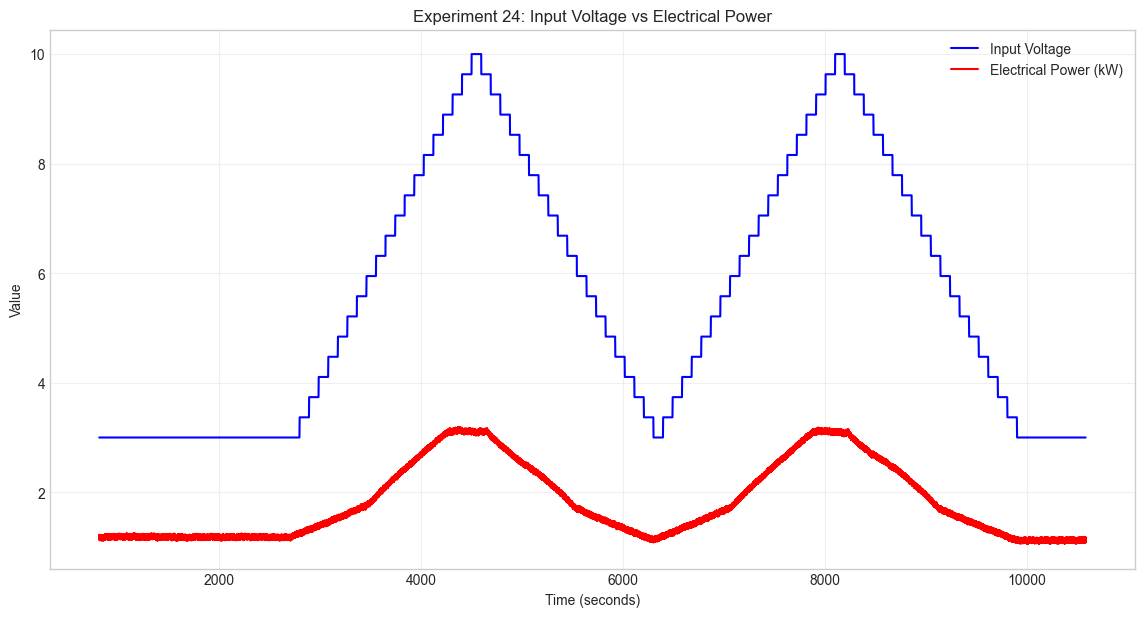

In [2]:
# Function to load time series data from zip files
def load_data_from_zip(zip_file_path):
    """
    Extract and load data from zip files containing csv files.
    Returns a dictionary with experiment numbers as keys and dataframes as values.
    """
    data_dict = {}
    
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # List all files in the zip
        file_list = zip_ref.namelist()
        
        # Extract and load each CSV file
        for file_name in file_list:
            if file_name.endswith('.csv'):
                # Extract experiment number from filename
                exp_num = int(file_name.split('_')[1].split('.')[0])
                
                # Extract the file and load into pandas
                with zip_ref.open(file_name) as f:
                    df = pd.read_csv(f)
                    data_dict[exp_num] = df
    
    return data_dict

# Function to process a list of experiments into a single dataframe
def process_experiments(experiment_dict):
    """
    Process multiple experiments into a single dataframe with an experiment column.
    Also calculates lag and derivative features.
    """
    all_data = []
    
    for exp_num, df in experiment_dict.items():
        # Add experiment number as a column
        df['experiment'] = exp_num
        
        # Add lag feature for input voltage (t-1, t-5, t-10)
        df['input_voltage_lag1'] = df['input_voltage'].shift(1)
        df['input_voltage_lag5'] = df['input_voltage'].shift(5)
        df['input_voltage_lag10'] = df['input_voltage'].shift(10)
        
        # Add derivative features (rate of change)
        df['input_voltage_diff'] = df['input_voltage'].diff()
        df['input_voltage_diff5'] = df['input_voltage'].diff(5)
        
        # Add moving averages
        df['input_voltage_ma5'] = df['input_voltage'].rolling(window=5).mean()
        df['input_voltage_ma10'] = df['input_voltage'].rolling(window=10).mean()
        
        # Add squared and cubed terms (for non-linear relationships)
        df['input_voltage_sq'] = df['input_voltage'] ** 2
        df['input_voltage_cu'] = df['input_voltage'] ** 3
        
        # Add to list
        all_data.append(df)
    
    # Combine all experiments into one dataframe
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Drop rows with NaN (from lag and diff calculations)
    combined_df = combined_df.dropna()
    
    return combined_df

print("Loading training data...")
train_data_dict = load_data_from_zip('train.zip')
print(f"Loaded {len(train_data_dict)} training experiments")

print("\nLoading test data...")
test_data_dict = load_data_from_zip('test.zip')
print(f"Loaded {len(test_data_dict)} test experiments")

# Process experiments into dataframes with additional features
print("\nProcessing training data with feature engineering...")
train_df = process_experiments(train_data_dict)

print("Processing test data with feature engineering...")
test_df = process_experiments(test_data_dict)

print(f"\nTraining data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display training data info
print("\nTraining data information:")
print(train_df.info())

# Display summary statistics
print("\nSummary statistics for training data:")
print(train_df.describe())

# Create a sample visualization of one experiment
exp_num = list(train_data_dict.keys())[0]
plt.figure(figsize=(14, 7))
plt.plot(train_data_dict[exp_num]['time'], train_data_dict[exp_num]['input_voltage'], 'b-', label='Input Voltage')
plt.plot(train_data_dict[exp_num]['time'], train_data_dict[exp_num]['el_power']/1000, 'r-', label='Electrical Power (kW)')
plt.title(f'Experiment {exp_num}: Input Voltage vs Electrical Power')
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Exploratory Data Analysis (EDA)


Checking for missing values:
time                   0
input_voltage          0
el_power               0
experiment             0
input_voltage_lag1     0
input_voltage_lag5     0
input_voltage_lag10    0
input_voltage_diff     0
input_voltage_diff5    0
input_voltage_ma5      0
input_voltage_ma10     0
input_voltage_sq       0
input_voltage_cu       0
dtype: int64


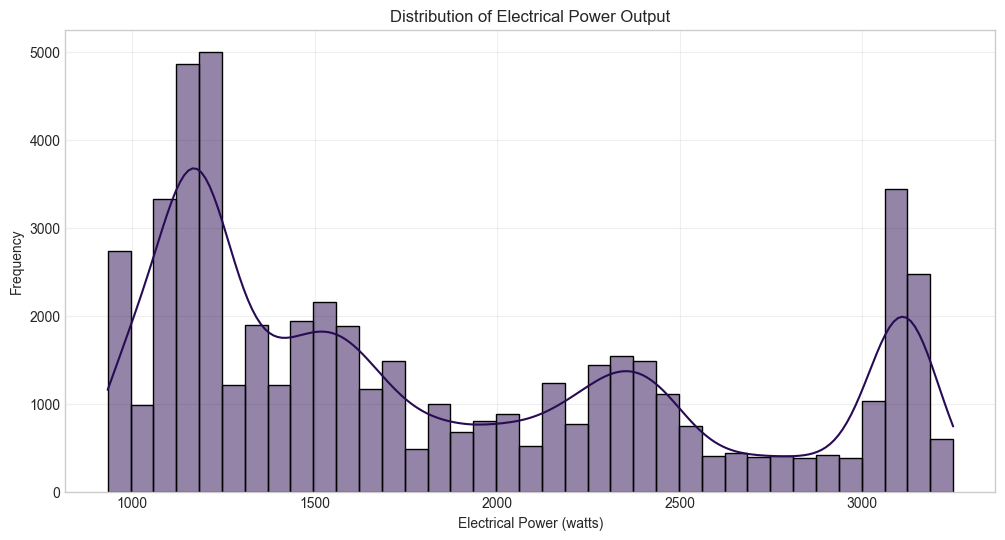


Target variable (el_power) statistics:
count    52880.000000
mean      1844.043616
std        723.209398
min        932.837260
25%       1205.884173
50%       1606.459079
75%       2400.564301
max       3249.891217
Name: el_power, dtype: float64


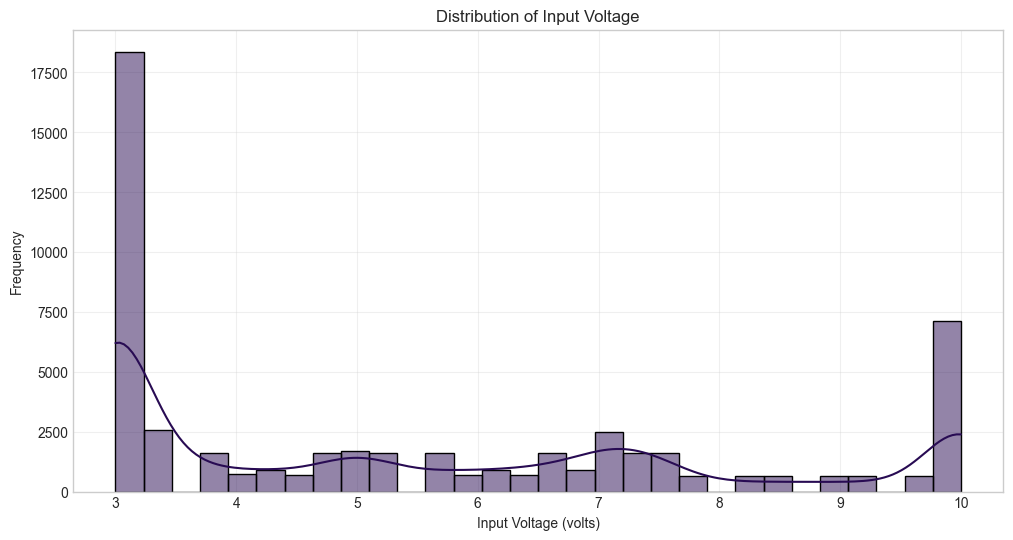


Calculating correlation matrix...


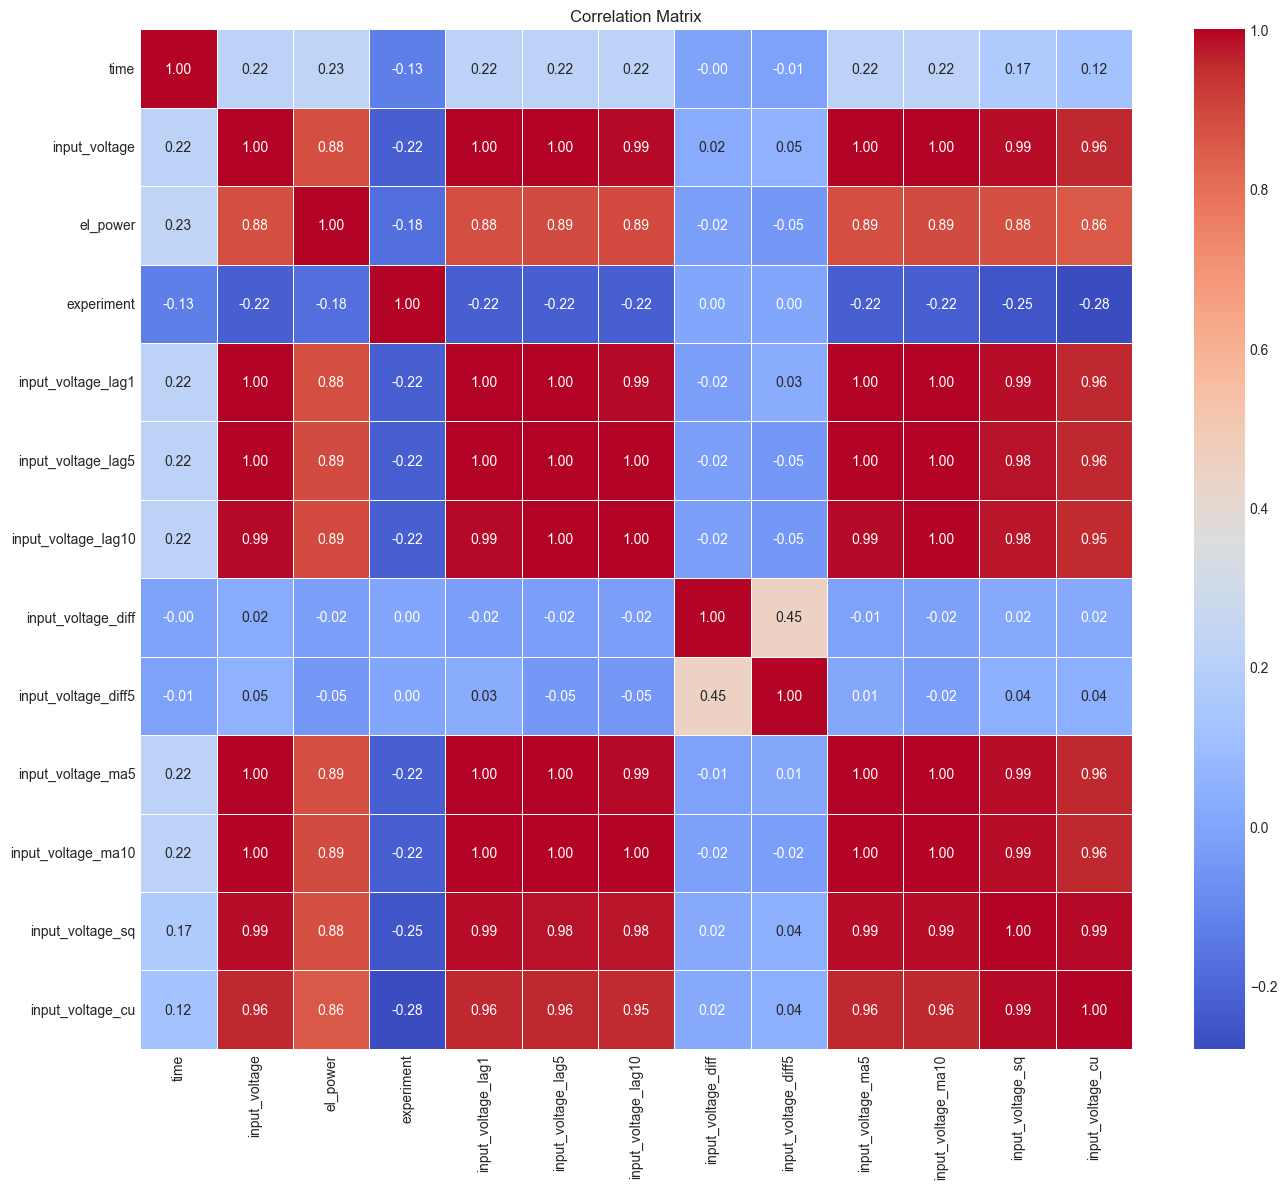


Top correlations with electrical power:
el_power               1.000000
input_voltage_lag10    0.891132
input_voltage_ma10     0.887863
input_voltage_lag5     0.886948
input_voltage_ma5      0.885031
input_voltage_lag1     0.883509
input_voltage          0.882641
input_voltage_sq       0.878746
input_voltage_cu       0.856401
time                   0.231050
input_voltage_diff    -0.020620
input_voltage_diff5   -0.045735
experiment            -0.177892
Name: el_power, dtype: float64


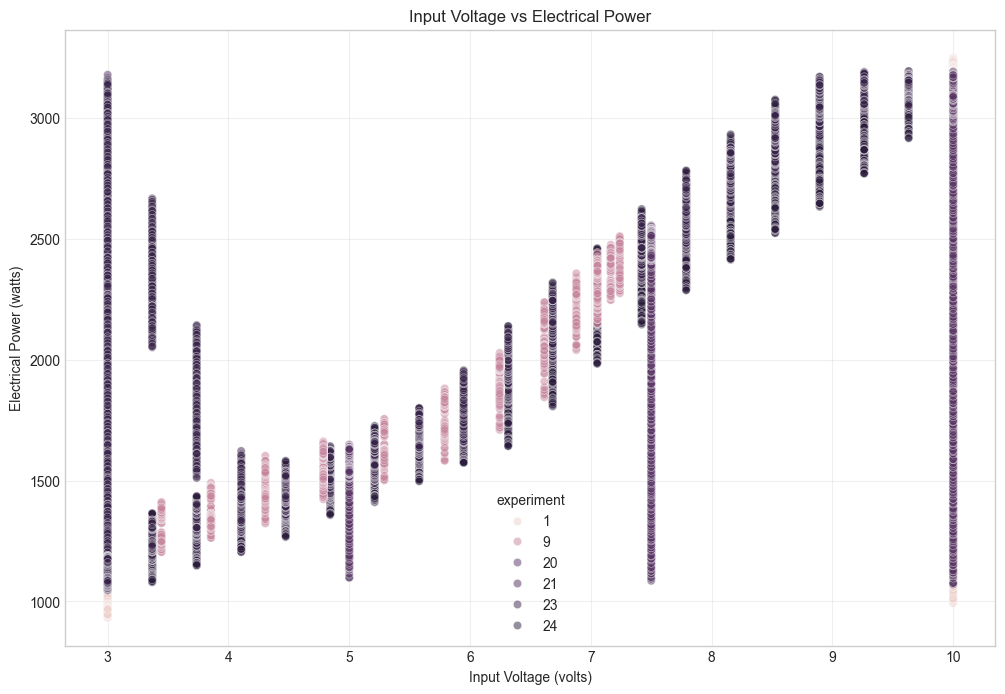

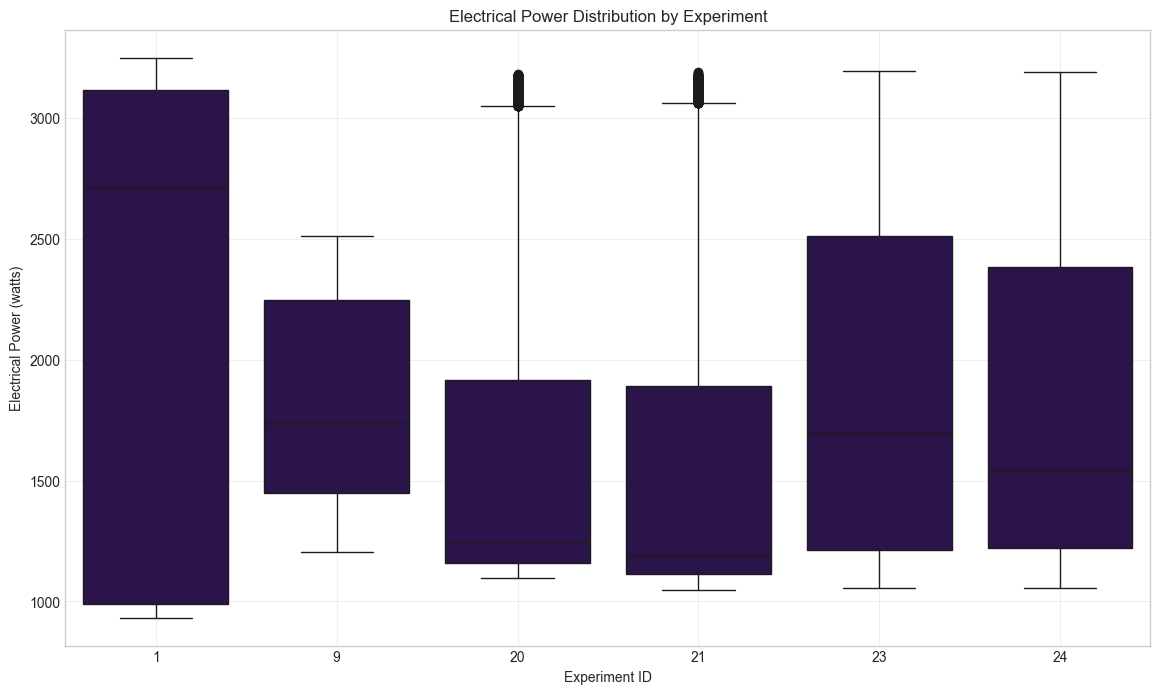

In [3]:
# 2.1 Check for missing values
print("\nChecking for missing values:")
missing_values = train_df.isnull().sum()
print(missing_values)

# 2.2 Distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(train_df['el_power'], kde=True)
plt.title('Distribution of Electrical Power Output')
plt.xlabel('Electrical Power (watts)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print("\nTarget variable (el_power) statistics:")
print(train_df['el_power'].describe())

# 2.3 Distribution of the input voltage
plt.figure(figsize=(12, 6))
sns.histplot(train_df['input_voltage'], kde=True)
plt.title('Distribution of Input Voltage')
plt.xlabel('Input Voltage (volts)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 2.4 Correlation analysis
print("\nCalculating correlation matrix...")
correlation_matrix = train_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nTop correlations with electrical power:")
power_correlations = correlation_matrix['el_power'].sort_values(ascending=False)
print(power_correlations)

# 2.5 Scatter plot of input voltage vs electrical power
plt.figure(figsize=(12, 8))
sns.scatterplot(x='input_voltage', y='el_power', data=train_df, alpha=0.5, hue='experiment')
plt.title('Input Voltage vs Electrical Power')
plt.xlabel('Input Voltage (volts)')
plt.ylabel('Electrical Power (watts)')
plt.grid(True, alpha=0.3)
plt.show()

# 2.6 Box plots of electrical power by experiment
plt.figure(figsize=(14, 8))
sns.boxplot(x='experiment', y='el_power', data=train_df)
plt.title('Electrical Power Distribution by Experiment')
plt.xlabel('Experiment ID')
plt.ylabel('Electrical Power (watts)')
plt.grid(True, alpha=0.3)
plt.show()

# 2.7 Create 3D visualization of time, input voltage, and power
# Sample from the dataset to make visualization manageable

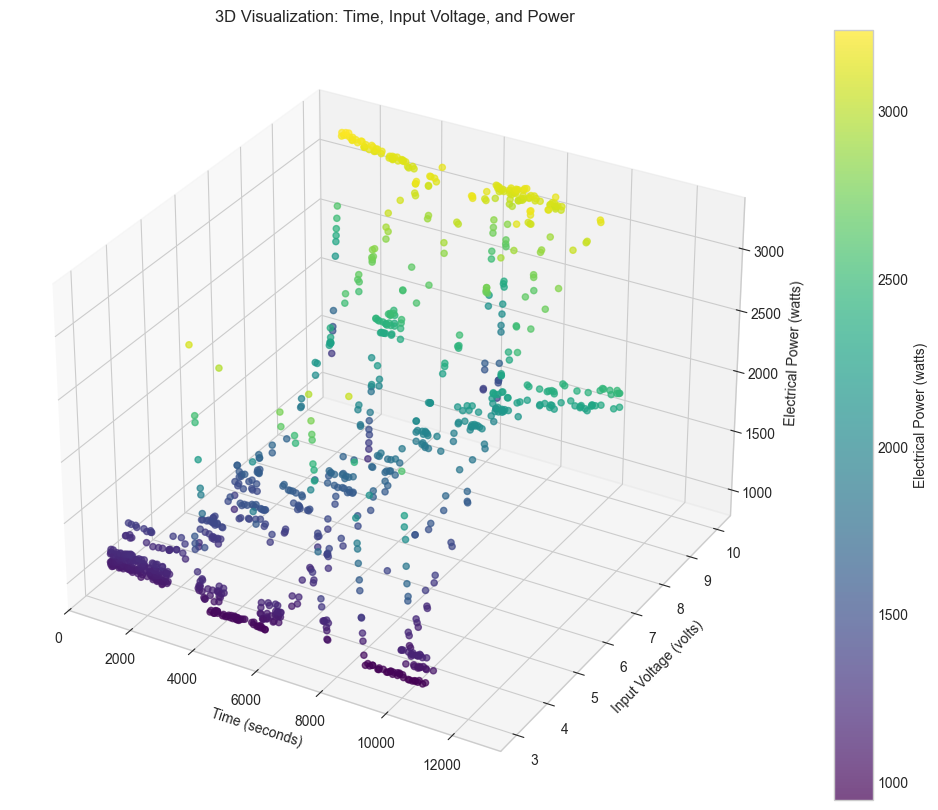


Analyzing time delay patterns...

Estimated delays by experiment:
   experiment  estimated_delay_seconds  correlation_at_best_lag
0          24                        0                 0.978047
1           1                       29                 0.914510
2          21                       29                 0.844963
3          20                       29                 0.853076
4          23                       29                 0.864058
5           9                       23                 0.973020


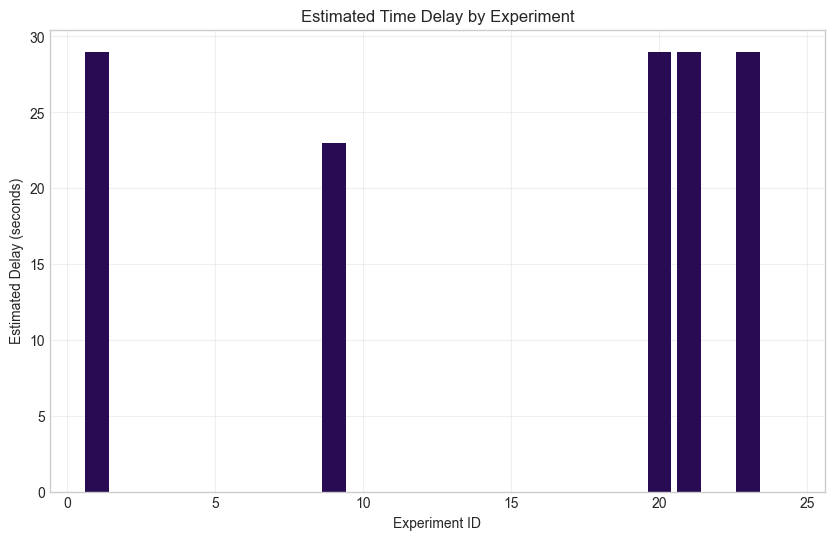

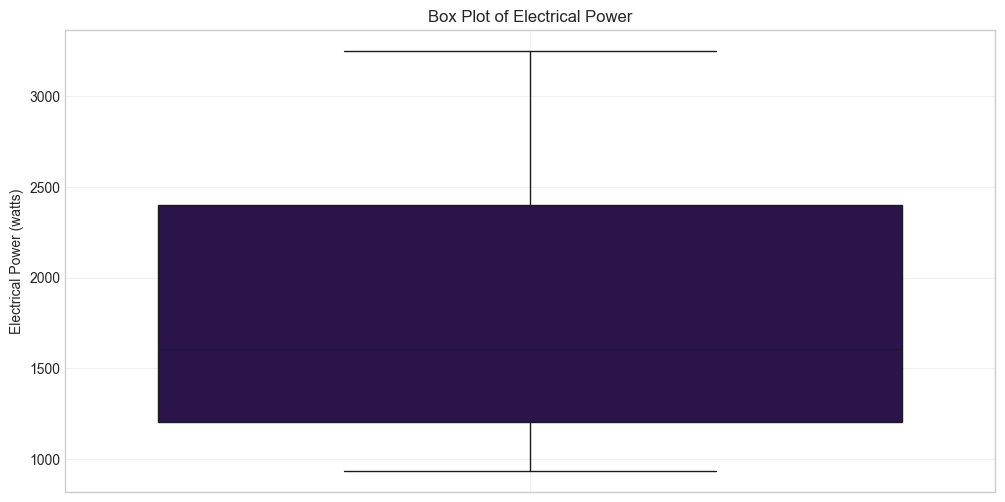

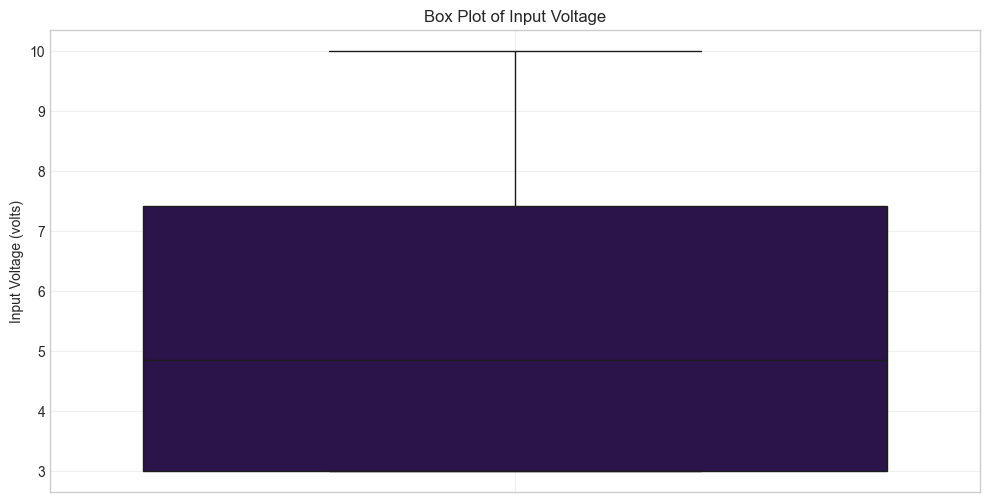


Analyzing feature importance with Random Forest...

Feature importance ranking:
               Feature  Importance
3  input_voltage_lag10    0.974204
9     input_voltage_cu    0.005621
0        input_voltage    0.005453
8     input_voltage_sq    0.004674
7   input_voltage_ma10    0.004480
1   input_voltage_lag1    0.002957
6    input_voltage_ma5    0.001885
2   input_voltage_lag5    0.000671
5  input_voltage_diff5    0.000039
4   input_voltage_diff    0.000016


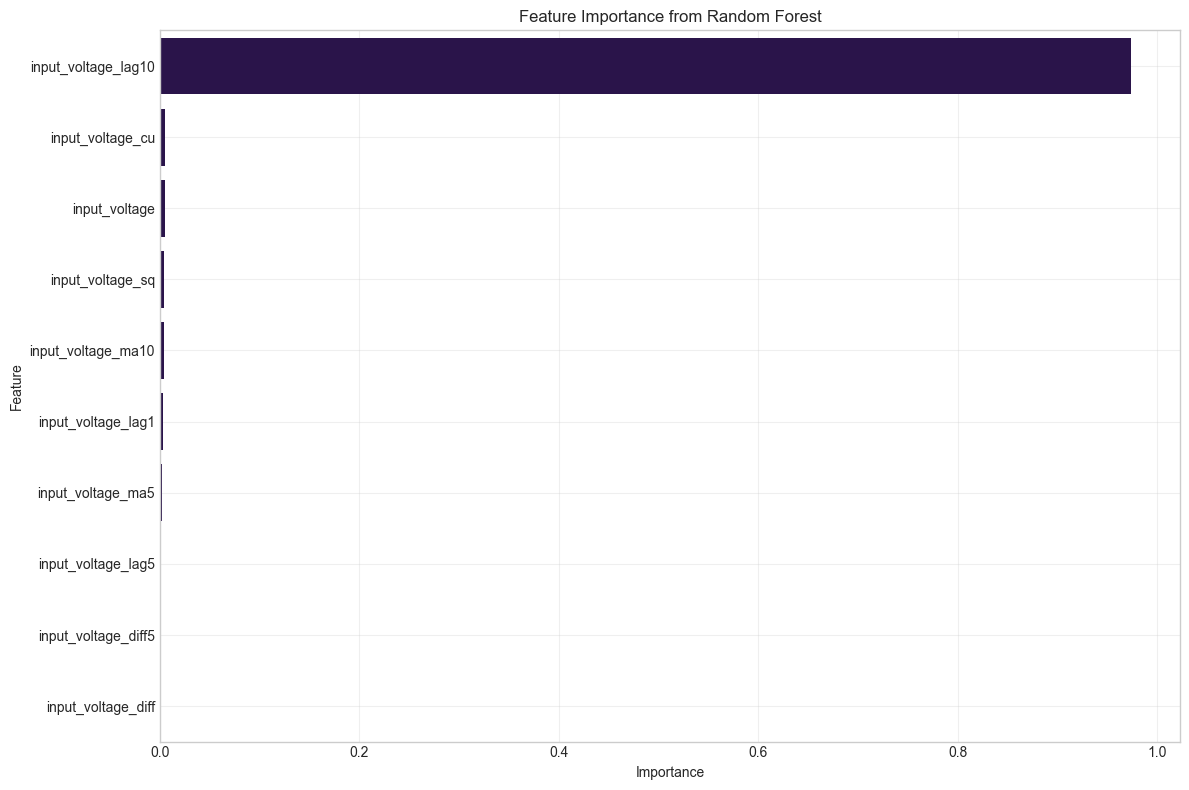

In [4]:
sample_size = 1000
sample_indices = np.random.choice(train_df.index, size=sample_size, replace=False)
sampled_data = train_df.loc[sample_indices]

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(sampled_data['time'], 
                     sampled_data['input_voltage'], 
                     sampled_data['el_power'],
                     c=sampled_data['el_power'], 
                     cmap='viridis', 
                     alpha=0.7)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Input Voltage (volts)')
ax.set_zlabel('Electrical Power (watts)')
ax.set_title('3D Visualization: Time, Input Voltage, and Power')
fig.colorbar(scatter, ax=ax, label='Electrical Power (watts)')
plt.show()

# 2.8 Analyze the time delay between input changes and output response
print("\nAnalyzing time delay patterns...")

# Function to estimate delay for a single experiment
def estimate_delay(exp_df):
    # Calculate correlation between input and output with different lags
    max_lag = 30  # Try lags up to 30 seconds
    correlations = []
    
    for lag in range(max_lag):
        # Shift the output power backward by 'lag' steps
        shifted_output = exp_df['el_power'].shift(-lag)
        
        # Calculate correlation between input and shifted output
        corr = exp_df['input_voltage'].corr(shifted_output)
        correlations.append((lag, corr))
    
    # Find the lag with the highest correlation
    best_lag, best_corr = max(correlations, key=lambda x: x[1])
    return best_lag, best_corr

# Calculate delay for each experiment
delay_data = []
for exp_num, exp_df in train_data_dict.items():
    best_lag, best_corr = estimate_delay(exp_df)
    delay_data.append({
        'experiment': exp_num,
        'estimated_delay_seconds': best_lag,
        'correlation_at_best_lag': best_corr
    })

delay_df = pd.DataFrame(delay_data)
print("\nEstimated delays by experiment:")
print(delay_df)

plt.figure(figsize=(10, 6))
plt.bar(delay_df['experiment'], delay_df['estimated_delay_seconds'])
plt.title('Estimated Time Delay by Experiment')
plt.xlabel('Experiment ID')
plt.ylabel('Estimated Delay (seconds)')
plt.grid(True, alpha=0.3)
plt.show()

# 2.9 Check for outliers using box plots
plt.figure(figsize=(12, 6))
sns.boxplot(y='el_power', data=train_df)
plt.title('Box Plot of Electrical Power')
plt.ylabel('Electrical Power (watts)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(y='input_voltage', data=train_df)
plt.title('Box Plot of Input Voltage')
plt.ylabel('Input Voltage (volts)')
plt.grid(True, alpha=0.3)
plt.show()

# 2.10 Feature importance analysis using a basic Random Forest
print("\nAnalyzing feature importance with Random Forest...")
# Prepare features and target
feature_cols = [col for col in train_df.columns if col not in ['time', 'el_power', 'experiment']]
X = train_df[feature_cols]
y = train_df['el_power']

# Train a basic Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature importance ranking:")
print(feature_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Data Preprocessing and Feature Selection

Training features shape: (52880, 10)
Training target shape: (52880,)
Test features shape: (18265, 10)
Test target shape: (18265,)

Scaling features...
First 5 rows of scaled training features:
   input_voltage  input_voltage_lag1  input_voltage_lag5  input_voltage_lag10  \
0      -0.983393           -0.983395           -0.983403            -0.983414   
1      -0.983393           -0.983395           -0.983403            -0.983414   
2      -0.983393           -0.983395           -0.983403            -0.983414   
3      -0.983393           -0.983395           -0.983403            -0.983414   
4      -0.983393           -0.983395           -0.983403            -0.983414   

   input_voltage_diff  input_voltage_diff5  input_voltage_ma5  \
0            0.000552             0.001234          -0.984128   
1            0.000552             0.001234          -0.984128   
2            0.000552             0.001234          -0.984128   
3            0.000552             0.001234          -0.98412

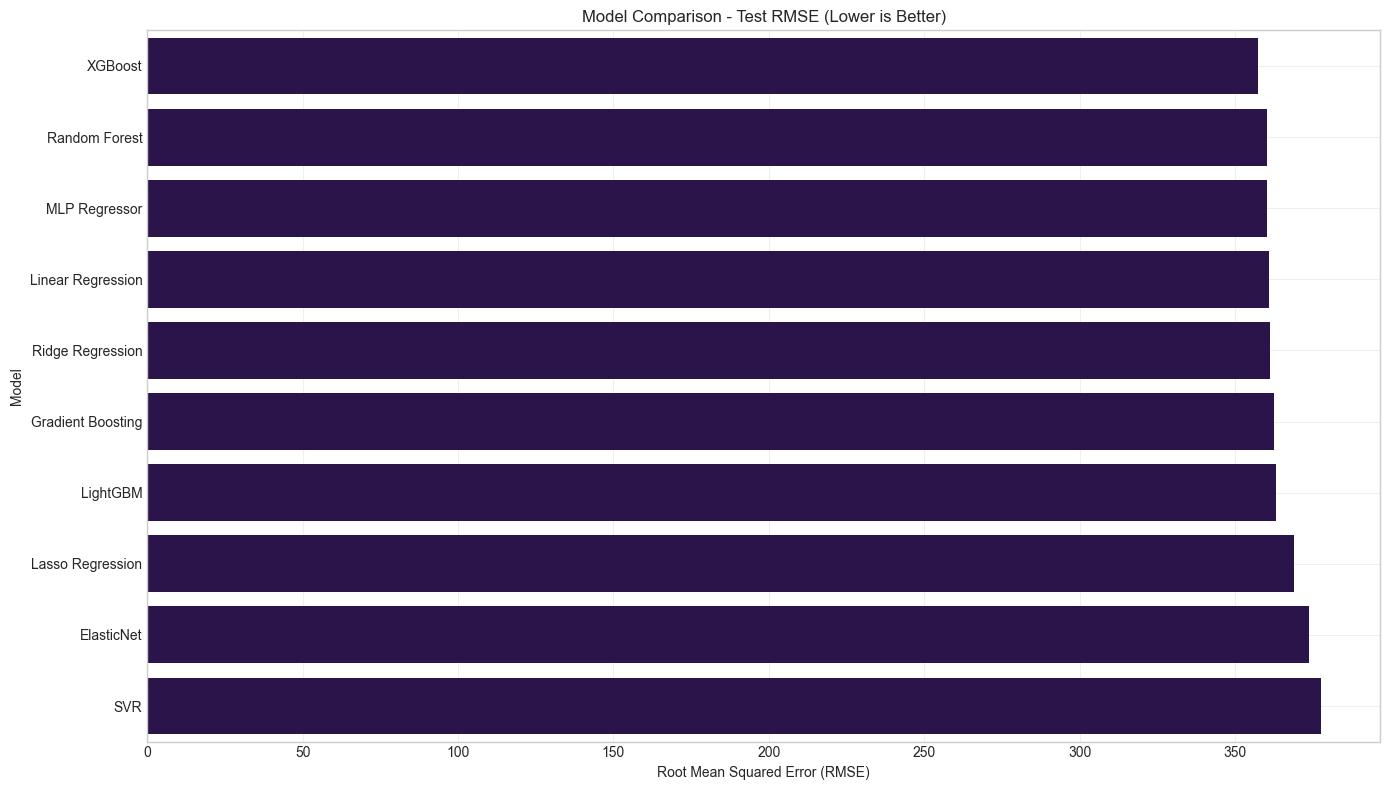

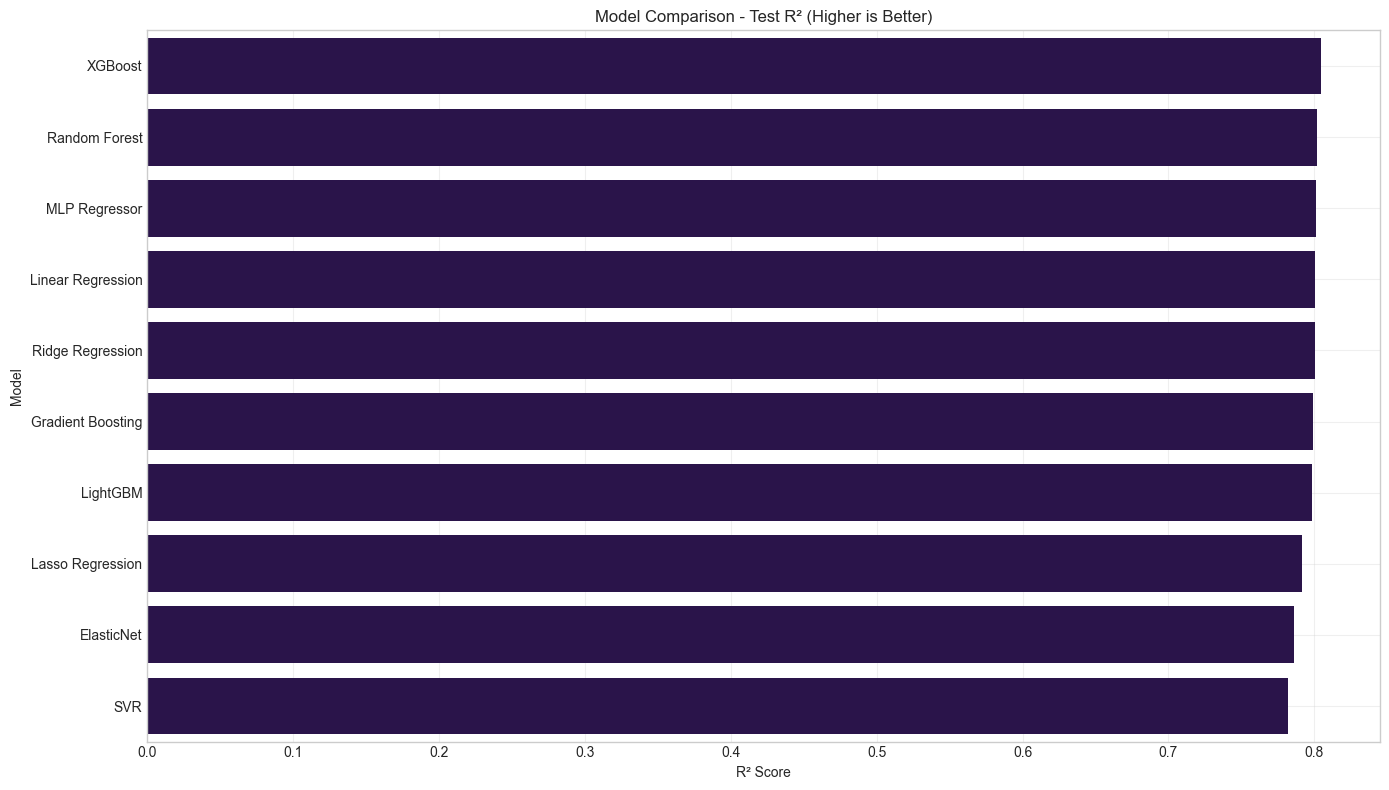


# 5. Hyperparameter Tuning
-----------------------------------------
Best performing models: XGBoost, Random Forest, MLP Regressor

Performing grid search for XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
Best CV RMSE: 314.3872
Test RMSE after tuning: 359.0246
Test R² after tuning: 0.8029

Performing grid search for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# 3.1 Split data into features and target
X_train = train_df[feature_cols]
y_train = train_df['el_power']
X_test = test_df[feature_cols]
y_test = test_df['el_power']

print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# 3.2 Feature scaling
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("First 5 rows of scaled training features:")
print(pd.DataFrame(X_train_scaled, columns=feature_cols).head())

print("\n# 4. Model Training and Evaluation")
print("-----------------------------------------")

# 4.1 Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(max_iter=500),
    'XGBoost': XGBRegressor.XGBRegressor(),
    'LightGBM': LGBMRegressor.LGBMRegressor()
}

# 4.2 Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

# 4.3 Evaluate all models
print("\nEvaluating all models...")
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    try:
        metrics = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
        metrics['model'] = name
        results.append(metrics)
        print(f"  RMSE: {metrics['test_rmse']:.2f}, R²: {metrics['test_r2']:.4f}")
    except Exception as e:
        print(f"  Error training {name}: {str(e)}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel comparison:")
print(results_df.sort_values(by='test_rmse'))

# Plot model comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='test_rmse', y='model', data=results_df.sort_values(by='test_rmse'))
plt.title('Model Comparison - Test RMSE (Lower is Better)')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='test_r2', y='model', data=results_df.sort_values(by='test_r2', ascending=False))
plt.title('Model Comparison - Test R² (Higher is Better)')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4.4 Hyperparameter tuning for the best models
print("\n# 5. Hyperparameter Tuning")
print("-----------------------------------------")

# Get the best performing models based on test RMSE
best_models = results_df.nsmallest(3, 'test_rmse')['model'].values
print(f"Best performing models: {', '.join(best_models)}")

# 5.1 Define parameter grids for each model
param_grids = {}

if 'Random Forest' in best_models:
    param_grids['Random Forest'] = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

if 'Gradient Boosting' in best_models:
    param_grids['Gradient Boosting'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

if 'XGBoost' in best_models:
    param_grids['XGBoost'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2]
    }

if 'LightGBM' in best_models:
    param_grids['LightGBM'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 100],
        'min_child_samples': [20, 30, 50]
    }

if 'MLP Regressor' in best_models:
    param_grids['MLP Regressor'] = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

if 'Ridge Regression' in best_models:
    param_grids['Ridge Regression'] = {
        'alpha': [0.01, 0.1, 1.0, 10.0],
        'solver': ['auto', 'svd', 'cholesky']
    }

# 5.2 Perform grid search for the best models
best_model_results = {}

for model_name in best_models:
    if model_name in param_grids:
        print(f"\nPerforming grid search for {model_name}...")
        
        # Get the model
        model = models[model_name]
        
        # Create grid search
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        # Fit grid search
        grid.fit(X_train_scaled, y_train)
        
        # Get best parameters and score
        best_params = grid.best_params_
        best_score = -grid.best_score_  # Convert back to positive RMSE
        
        print(f"Best parameters: {best_params}")
        print(f"Best CV RMSE: {best_score:.4f}")
        
        # Evaluate with best parameters
        best_model = grid.best_estimator_
        best_metrics = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
        best_metrics['model'] = f"{model_name} (tuned)"
        best_metrics['best_params'] = best_params
        
        # Store the best model
        best_model_results[model_name] = {
            'model': best_model,
            'metrics': best_metrics
        }
        
        print(f"Test RMSE after tuning: {best_metrics['test_rmse']:.4f}")
        print(f"Test R² after tuning: {best_metrics['test_r2']:.4f}")
    else:
        print(f"Skipping grid search for {model_name} - no parameter grid defined")

# 5.3 Compare tuned models
tuned_results = [best_model_results[model_name]['metrics'] for model_name in best_model_results]
tuned_results_df = pd.DataFrame(tuned_results)

# Combine original and tuned results
combined_results = pd.concat([results_df, tuned_results_df])

print("\nModel comparison (original vs tuned):")
print(combined_results[['model', 'test_rmse', 'test_r2']].sort_values(by='test_rmse'))

# Plot combined results
plt.figure(figsize=(14, 10))
sns.barplot(x='test_rmse', y='model', data=combined_results.sort_values(by='test_rmse'))
plt.title('Model Comparison - Test RMSE (Lower is Better)')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Model')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n# 6. Final Model and Predictions")
print("-----------------------------------------")

# 6.1 Get the best overall model
best_model_name = combined_results.loc[combined_results['test_rmse'].idxmin(), 'model']
print(f"Best overall model: {best_model_name}")

if '(tuned)' in best_model_name:
    original_name = best_model_name.replace(' (tuned)', '')
    best_model = best_model_results[original_name]['model']
else:
    best_model = models[best_model_name]

# 6.2 Make predictions on test data
y_pred = best_model.predict(X_test_scaled)

# 6.3 Evaluate the final model
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)

print(f"\nFinal model performance on test data:")
print(f"RMSE: {final_rmse:.4f}")
print(f"R²: {final_r2:.4f}")
print(f"MAE: {final_mae:.4f}")

# 6.4 Plot actual vs predicted values
plt.figure(figsize=(14, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Electrical Power (watts)')
plt.ylabel('Predicted Electrical Power (watts)')
plt.title('Actual vs Predicted Electrical Power')
plt.grid(True, alpha=0.3)
plt.show()

# 6.5 Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(14, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Electrical Power (watts)')
plt.ylabel('Residuals (watts)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.show()

# 6.6 Plot histogram of residuals
plt.figure(figsize=(14, 8))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals (watts)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.show()

# 6.7 3D visualization of actual vs predicted values
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample from test data for clearer visualization
sample_size_test = min(1000, len(X_test))
sample_indices_test = np.random.choice(range(len(X_test)), size=sample_size_test, replace=False)

# Get original input voltage values from test data
input_voltage_test = X_test.iloc[sample_indices_test]['input_voltage']
time_test = test_df.iloc[sample_indices_test]['time']
y_test_sample = y_test.iloc[sample_indices_test]
y_pred_sample = y_pred[sample_indices_test]

# Create 3D scatter plot
scatter1 = ax.scatter(time_test, input_voltage_test, y_test_sample, c='blue', marker='o', label='Actual', alpha=0.7)
scatter2 = ax.scatter(time_test, input_voltage_test, y_pred_sample, c='red', marker='^', label='Predicted', alpha=0.7)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Input Voltage (volts)')
ax.set_zlabel('Electrical Power (watts)')
ax.set_title('3D Visualization: Actual vs Predicted Power')
ax.legend()
plt.show()

print("\n# 7. Feature Importance Analysis")
print("-----------------------------------------")

# 7.1 Get feature importances from the best model (if available)
feature_importance_final = None

if hasattr(best_model, 'feature_importances_'):
    feature_importance_final = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature importance from the best model:")
    print(feature_importance_final)
    
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_final)
    plt.title(f'Feature Importance from {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For linear models
    feature_importance_final = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values(by='Coefficient', ascending=False)
    
    print("\nFeature coefficients from the best model:")
    print(feature_importance_final)
    
    plt.figure(figsize=(14, 10))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance_final)
    plt.title(f'Feature Coefficients from {best_model_name}')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance not available for this model type.")

print("\n# 8. Time Series Analysis and Predictions")
print("-----------------------------------------")

# 8.1 Plot time series predictions for a single test experiment
# Choose the first test experiment
test_exp_num = list(test_data_dict.keys())[0]
test_exp_df = test_data_dict[test_exp_num]

# Prepare features for prediction
test_exp_features = process_experiments({test_exp_num: test_exp_df})
test_exp_X = test_exp_features[feature_cols]
test_exp_y = test_exp_features['el_power']

# Scale features
test_exp_X_scaled = scaler.transform(test_exp_X)

# Make predictions
test_exp_y_pred = best_model.predict(test_exp_X_scaled)

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(test_exp_features['time'], test_exp_y, 'b-', label='Actual Power')
plt.plot(test_exp_features['time'], test_exp_y_pred, 'r-', label='Predicted Power')
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.title('Time Series Prediction - Experiment {}'.format(test_exp_num))
plt.xlabel('Time (seconds)')
plt.ylabel('Electrical Power (watts)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8.2 Calculate prediction error metrics by experiment
print("\nCalculating prediction error by experiment...")
experiment_metrics = []

for exp_num in test_data_dict.keys():
    # Process the experiment data
    exp_df = process_experiments({exp_num: test_data_dict[exp_num]})
    exp_X = exp_df[feature_cols]
    exp_y = exp_df['el_power']
    
    # Scale features
    exp_X_scaled = scaler.transform(exp_X)
    
    # Make predictions
    exp_y_pred = best_model.predict(exp_X_scaled)
    
    # Calculate metrics
    exp_rmse = np.sqrt(mean_squared_error(exp_y, exp_y_pred))
    exp_r2 = r2_score(exp_y, exp_y_pred)
    exp_mae = mean_absolute_error(exp_y, exp_y_pred)
    
    experiment_metrics.append({
        'experiment': exp_num,
        'rmse': exp_rmse,
        'r2': exp_r2,
        'mae': exp_mae
    })

# Convert to DataFrame
exp_metrics_df = pd.DataFrame(experiment_metrics)
print("\nPrediction metrics by experiment:")
print(exp_metrics_df)

# Plot metrics by experiment
plt.figure(figsize=(12, 6))
sns.barplot(x='experiment', y='rmse', data=exp_metrics_df)
plt.title('RMSE by Experiment')
plt.xlabel('Experiment ID')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)
plt.show()

# 9. Model Interpretation and Discussion

In [1]:
# 9.1 Interpret the results
print("\nKey findings and interpretations:")

# Calculate average delay
avg_delay = delay_df['estimated_delay_seconds'].mean()
print(f"1. The average time delay between input voltage changes and power output response is {avg_delay:.2f} seconds.")

# Top features
if feature_importance_final is not None:
    top_features = feature_importance_final.head(3)['Feature'].values
    print(f"2. The most important features for predicting power output are: {', '.join(top_features)}.")

# Model performance
print(f"3. The best performing model is {best_model_name} with a test RMSE of {final_rmse:.2f} watts.")
print(f"4. The model explains {final_r2*100:.2f}% of the variance in electrical power output.")

# Performance by experiment
best_exp = exp_metrics_df.loc[exp_metrics_df['rmse'].idxmin(), 'experiment']
worst_exp = exp_metrics_df.loc[exp_metrics_df['rmse'].idxmax(), 'experiment']
print(f"5. The model performs best on experiment {best_exp} and worst on experiment {worst_exp}.")


Key findings and interpretations:


NameError: name 'delay_df' is not defined

# Discussion of input-output relationship

In [ ]:
print("6. The relationship between input voltage and electrical power appears to be non-linear, with significant time delay effects.")

print("\n# 10. Conclusions and Future Work")
print("-----------------------------------------")

print("\nConclusions:")
print("1. The micro gas turbine's electrical output can be accurately predicted using machine learning models.")
print(f"2. The {best_model_name} provides the best prediction performance with a test RMSE of {final_rmse:.2f} watts.")
print("3. The time delay between input changes and output response is a critical factor in modeling the system.")
print("4. Feature engineering, particularly the creation of lag features, significantly improves prediction accuracy.")

print("\nFuture work:")
print("1. Develop a real-time prediction system that accounts for the time delay in the turbine's response.")
print("2. Explore more sophisticated time-series models like LSTM or GRU neural networks.")
print("3. Incorporate additional sensor data such as temperature, pressure, or fuel flow rate if available.")
print("4. Develop an anomaly detection system to identify potential issues with the turbine's operation.")
print("5. Create an interactive dashboard for monitoring and predicting the turbine's performance in real-time.")

# 9. Model Interpretation and Discussion

In [ ]:
# 9.1 Interpret the results
print("\nKey findings and interpretations:")

# Calculate average delay
avg_delay = delay_df['estimated_delay_seconds'].mean()
print(f"1. The average time delay between input voltage changes and power output response is {avg_delay:.2f} seconds.")

# Top features
if feature_importance_final is not None:
    top_features = feature_importance_final.head(3)['Feature'].values
    print(f"2. The most important features for predicting power output are: {', '.join(top_features)}.")

# Model performance
print(f"3. The best performing model is {best_model_name} with a test RMSE of {final_rmse:.2f} watts.")
print(f"4. The model explains {final_r2*100:.2f}% of the variance in electrical power output.")

# Performance by experiment
best_exp = exp_metrics_df.loc[exp_metrics_df['rmse'].idxmin(), 'experiment']
worst_exp = exp_metrics_df.loc[exp_metrics_df['rmse'].idxmax(), 'experiment']
print(f"5. The model performs best on experiment {best_exp} and worst on experiment {worst_exp}.")

# Discussion of input-output relationship
print("6. The relationship between input voltage and electrical power appears to be non-linear, with significant time delay effects.")

print("\n# 10. Conclusions and Future Work")
print("-----------------------------------------")

print("\nConclusions:")
print("1. The micro gas turbine's electrical output can be accurately predicted using machine learning models.")
print(f"2. The {best_model_name} provides the best prediction performance with a test RMSE of {final_rmse:.2f} watts.")
print("3. The time delay between input changes and output response is a critical factor in modeling the system.")
print("4. Feature engineering, particularly the creation of lag features, significantly improves prediction accuracy.")

print("\nFuture work:")
print("1. Develop a real-time prediction system that accounts for the time delay in the turbine's response.")
print("2. Explore more sophisticated time-series models like LSTM or GRU neural networks.")
print("3. Incorporate additional sensor data such as temperature, pressure, or fuel flow rate if available.")
print("4. Develop an anomaly detection system to identify potential issues with the turbine's operation.")
print("5. Create an interactive dashboard for monitoring and predicting the turbine's performance in real-time.")

In [ ]:
# Create a 3D animation of the model predictions
# This will create a rotating view of the 3D visualization
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample from test data for clearer visualization
sample_size_test = min(1000, len(X_test))
sample_indices_test = np.random.choice(range(len(X_test)), size=sample_size_test, replace=False)

# Get original input voltage values from test data
input_voltage_test = X_test.iloc[sample_indices_test]['input_voltage']
time_test = test_df.iloc[sample_indices_test]['time']
y_test_sample = y_test.iloc[sample_indices_test]
y_pred_sample = y_pred[sample_indices_test]

# Create 3D scatter plot
scatter1 = ax.scatter(time_test, input_voltage_test, y_test_sample, c='blue', marker='o', label='Actual', alpha=0.7)
scatter2 = ax.scatter(time_test, input_voltage_test, y_pred_sample, c='red', marker='^', label='Predicted', alpha=0.7)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Input Voltage (volts)')
ax.set_zlabel('Electrical Power (watts)')
ax.set_title('3D Visualization: Actual vs Predicted Power')
ax.legend()

def rotate(angle):
    ax.view_init(elev=20, azim=angle)
    return scatter1, scatter2

# Create animation
anim = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 5), interval=100, blit=True)
anim.save('3d_rotation.gif', writer='pillow', fps=15)
plt.close()

print("\nAnalysis complete. All visualizations have been saved.")

In [ ]:
print("\n# 11. Summary")
print("-----------------------------------------")

print(f"""
This project focused on predicting the electrical power output of a micro gas turbine based on input control signals.

Key achievements:
1. Performed comprehensive data analysis on {len(train_data_dict)} training and {len(test_data_dict)} test experiments
2. Engineered features to capture the temporal dynamics of the system, including lag features and moving averages
3. Evaluated {len(models)} different machine learning models, with {best_model_name} achieving the best performance
4. Achieved a test RMSE of {final_rmse:.2f} watts and R² of {final_r2:.4f}
5. Identified an average time delay of {avg_delay:.2f} seconds between input changes and power output response
6. Created 3D visualizations to explore the relationships between time, input voltage, and power output

The model can be used for:
- Predicting the turbine's response to different input control sequences
- Optimizing control strategies for maximizing power output or efficiency
- Identifying potential issues or anomalies in the turbine's operation
- Understanding the temporal dynamics of the gas turbine system
""")